## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [13]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [14]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

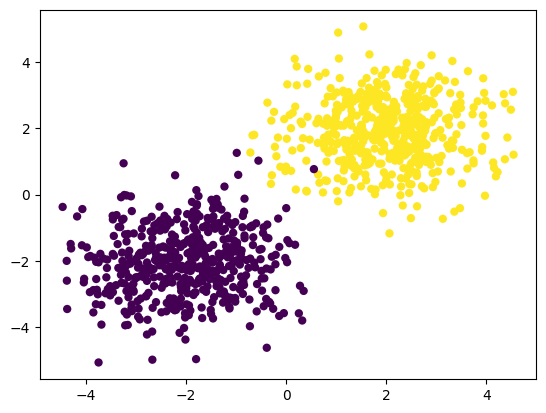

In [15]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [16]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [17]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [18]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

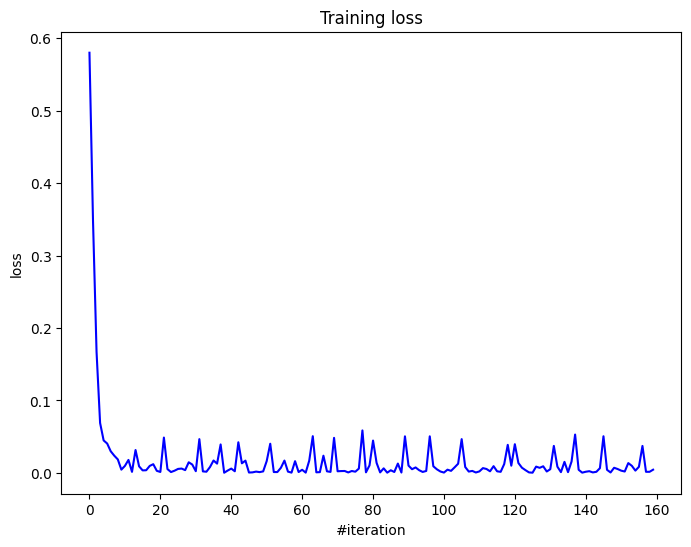

Current loss: 0.004482


In [19]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [20]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [21]:
# Your code goes here. ################################################
n_classes = 10

def one_hot_encode(n_classes, y):
    y_one_hot = np.zeros((len(y), n_classes), dtype=float)
    y_one_hot[np.arange(len(y)), y.astype(int)] = 1.
    return y_one_hot

y_train = one_hot_encode(n_classes, y_train)
y_val = one_hot_encode(n_classes, y_val)
y_test = one_hot_encode(n_classes, y_test)

In [22]:
n_in = X_train.shape[1] * X_train.shape[2]

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [23]:
# Your code goes here. ################################################
from tqdm import tqdm

def build_model(activation_function, with_norm=False):
    net = Sequential()
    net.add(Flatten())
    net.add(Linear(n_in, 128))
    net.add(activation_function)
    if with_norm:
        net.add(BatchNormalization(alpha=0.1))
        net.add(ChannelwiseScaling(128))
    net.add(Linear(128, n_classes))
    net.add(LogSoftMax())
    return net

def train_loop(model, X, y, batch_size, n_epoch, criterion, optimizer, optimizer_config, X_val, y_val):
    train_loss_history = []
    val_loss_history = []
    optimizer_state = {}

    for _ in tqdm(range(n_epoch)):
        model.train()
        for x_batch, y_batch in get_batches((X, y), batch_size):
            
            model.zeroGradParameters()
            
            # Forward
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)
            
            # Update weights
            optimizer(model.getParameters(), 
                        model.getGradParameters(), 
                        optimizer_config,
                        optimizer_state)      
            
            train_loss_history.append(loss)
        
        model.evaluate()
        predictions = model.forward(X_val)
        val_loss = criterion.forward(predictions, y_val)
        val_loss_history.append(val_loss)
    
    return train_loss_history, val_loss_history

def plot_losses(train_losses, val_losses, labels):
    for loss, label in zip(train_losses, labels):
        plt.plot(loss, label=label)
    plt.title('Train Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

    for loss, label in zip(train_losses, labels):
        print(f'Train Loss {label}: {loss[-1]}')

    for loss, label in zip(val_losses, labels):
        plt.plot(loss, label=label)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

    for loss, label in zip(val_losses, labels):
        print(f'Validation Loss {label}: {loss[-1]}')

In [24]:
activation_functions = (ReLU(), ELU(), LeakyReLU(), SoftPlus())
train_losses = []
val_losses = []
labels = []

optimizer = sgd_momentum
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}

criterion = ClassNLLCriterion()

n_epoch = 10
batch_size = 512

for act_func in activation_functions:
    model = build_model(act_func)
    train_loss_history, val_loss_history = train_loop(model=model , X=X_train, y=y_train,
                                                      batch_size=batch_size, n_epoch=n_epoch, criterion=criterion,
                                                      optimizer=optimizer, optimizer_config=optimizer_config, 
                                                      X_val=X_val, y_val=y_val)
    train_losses.append(train_loss_history)
    val_losses.append(val_loss_history)
    labels.append(str(act_func))

    model = build_model(act_func, with_norm=True)
    train_loss_history, val_loss_history = train_loop(model=model , X=X_train, y=y_train,
                                                      batch_size=batch_size, n_epoch=n_epoch, criterion=criterion,
                                                      optimizer=optimizer, optimizer_config=optimizer_config, 
                                                      X_val=X_val, y_val=y_val)
    train_losses.append(train_loss_history)
    val_losses.append(val_loss_history)
    labels.append(f'{str(act_func)} with BatchNorm')

100%|██████████| 10/10 [01:18<00:00,  7.86s/it]


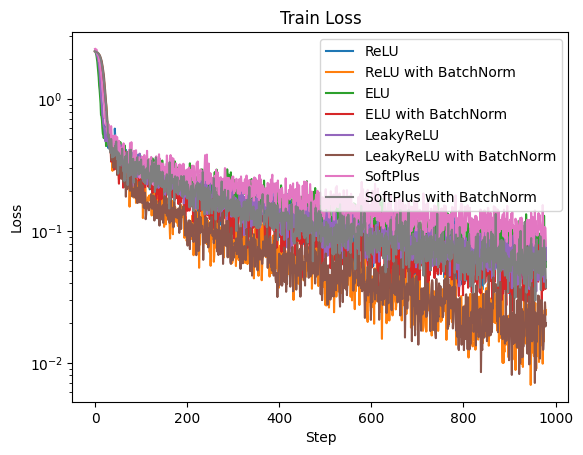

Train Loss ReLU: 0.05868555053786716
Train Loss ReLU with BatchNorm: 0.024951141885267338
Train Loss ELU: 0.0532970458142093
Train Loss ELU with BatchNorm: 0.042159231336401475
Train Loss LeakyReLU: 0.06018655378816578
Train Loss LeakyReLU with BatchNorm: 0.01995710231318449
Train Loss SoftPlus: 0.07747696362725046
Train Loss SoftPlus with BatchNorm: 0.03717907410479804


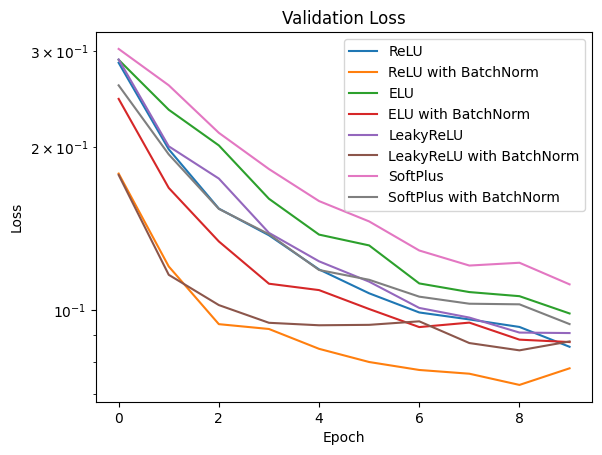

Validation Loss ReLU: 0.08548122261524616
Validation Loss ReLU with BatchNorm: 0.07800892458356033
Validation Loss ELU: 0.09848759615651574
Validation Loss ELU with BatchNorm: 0.08721923367495324
Validation Loss LeakyReLU: 0.09061833705177365
Validation Loss LeakyReLU with BatchNorm: 0.08744289657183076
Validation Loss SoftPlus: 0.11145494817649235
Validation Loss SoftPlus with BatchNorm: 0.09414215217146898


In [25]:
plot_losses(np.array(train_losses), np.array(val_losses), labels)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

_The best activation for functions in our case where ReLU and LeakyReLU, computation time based on tqdm output seems pretty much the same. Batch Normalization helps a little in this case._

In [26]:
learning_rates = np.logspace(-1, -4, 4)
activation_function = ReLU()
train_losses = []
val_losses = []
labels = [f'SGD: learning rate = {lr}' for lr in learning_rates]

optimizer = sgd_momentum
criterion = ClassNLLCriterion()

n_epoch = 10
batch_size = 512

for lr in learning_rates:
    model = build_model(activation_function, with_norm=True)
    optimizer_config = {'learning_rate' : lr, 'momentum': 0.9}
    train_loss_history, val_loss_history = train_loop(model=model , X=X_train, y=y_train,
                                                      batch_size=batch_size, n_epoch=n_epoch, criterion=criterion,
                                                      optimizer=optimizer, optimizer_config=optimizer_config, 
                                                      X_val=X_val, y_val=y_val)
    train_losses.append(train_loss_history)
    val_losses.append(val_loss_history)

100%|██████████| 10/10 [01:18<00:00,  7.84s/it]


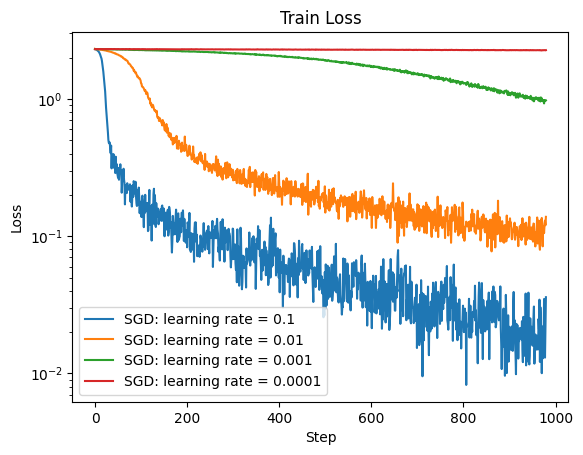

Train Loss SGD: learning rate = 0.1: 0.03594134814705322
Train Loss SGD: learning rate = 0.01: 0.13829088511752902
Train Loss SGD: learning rate = 0.001: 0.9739719100326728
Train Loss SGD: learning rate = 0.0001: 2.262033842217169


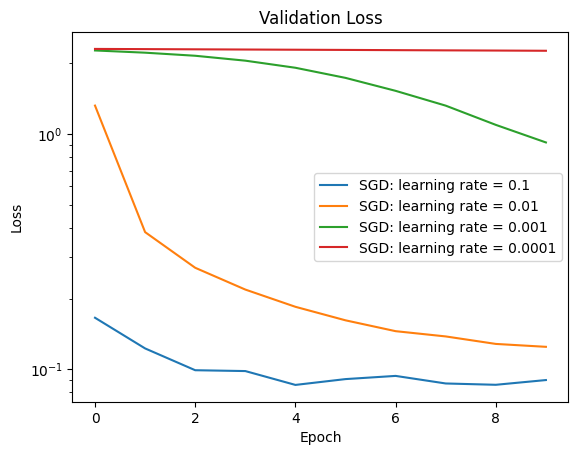

Validation Loss SGD: learning rate = 0.1: 0.0900407796211572
Validation Loss SGD: learning rate = 0.01: 0.12464519678015454
Validation Loss SGD: learning rate = 0.001: 0.9212458567087622
Validation Loss SGD: learning rate = 0.0001: 2.2595326247814023


In [27]:
plot_losses(np.array(train_losses), np.array(val_losses), labels)

In [28]:
learning_rates = np.logspace(-1, -4, 4)
activation_function = ReLU()
train_losses = []
val_losses = []
labels = [f'Adam: learning rate = {lr}' for lr in learning_rates]

optimizer = adam_optimizer
criterion = ClassNLLCriterion()

n_epoch = 10
batch_size = 512

for lr in learning_rates:
    model = build_model(activation_function, with_norm=True)
    optimizer_config = optimizer_config = {'learning_rate' : lr, 'beta1': 0.9, 'beta2': 0.999, 'epsilon':1e-8}
    train_loss_history, val_loss_history = train_loop(model=model , X=X_train, y=y_train,
                                                      batch_size=batch_size, n_epoch=n_epoch, criterion=criterion,
                                                      optimizer=optimizer, optimizer_config=optimizer_config, 
                                                      X_val=X_val, y_val=y_val)
    train_losses.append(train_loss_history)
    val_losses.append(val_loss_history)

100%|██████████| 10/10 [01:17<00:00,  7.78s/it]


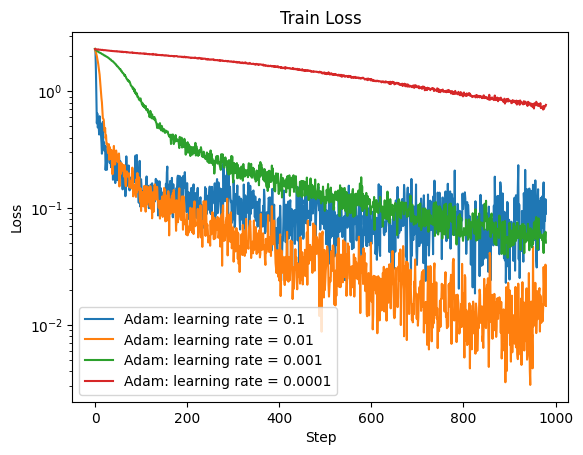

Train Loss Adam: learning rate = 0.1: 0.08958357751085769
Train Loss Adam: learning rate = 0.01: 0.014518979970072666
Train Loss Adam: learning rate = 0.001: 0.05064288327701962
Train Loss Adam: learning rate = 0.0001: 0.7657569046996234


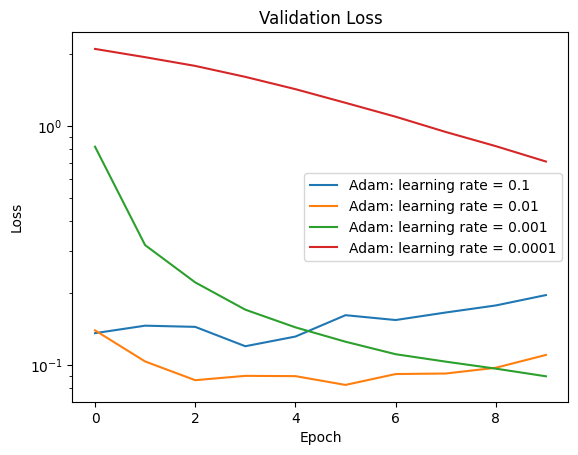

Validation Loss Adam: learning rate = 0.1: 0.19657559569484523
Validation Loss Adam: learning rate = 0.01: 0.11039187030913525
Validation Loss Adam: learning rate = 0.001: 0.0898630497866838
Validation Loss Adam: learning rate = 0.0001: 0.7122428294219836


In [29]:
plot_losses(np.array(train_losses), np.array(val_losses), labels)

_Adam in general performed better than SGD (except lr = 0.1)_

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

_Learning rate decay is added to the PyTorch implementation using `torch.optim.lr_scheduler.StepLR`_

In [30]:
# Your code goes here. ################################################
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [31]:
# Your answer goes here. ################################################
model = Sequential()
model.add(Flatten())
model.add(Linear(X_train.shape[1] * X_train.shape[2], 128))
model.add(ReLU())
model.add(Dropout())
model.add(BatchNormalization(alpha=0.1))
model.add(ChannelwiseScaling(128))
model.add(Linear(128, n_classes))
model.add(LogSoftMax())

print(model)

n_epoch = 10
batch_size = 512
optimizer = adam_optimizer
optimizer_config = {'learning_rate' : 1e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon':1e-8}
criterion = ClassNLLCriterion()

Flatten
Linear 784 -> 128
ReLU
Dropout
BatchNormalization
ChannelwiseScaling
Linear 128 -> 10
LogSoftMax



In [32]:
train_losses, val_losses = train_loop(model=model, X=X_train, y=one_hot_encode(n_classes, y_train),
                                      n_epoch=10, batch_size=512, criterion=criterion,
                                      optimizer=optimizer, optimizer_config=optimizer_config,
                                      X_val=X_val, y_val=one_hot_encode(n_classes, y_val))

100%|██████████| 10/10 [01:18<00:00,  7.83s/it]


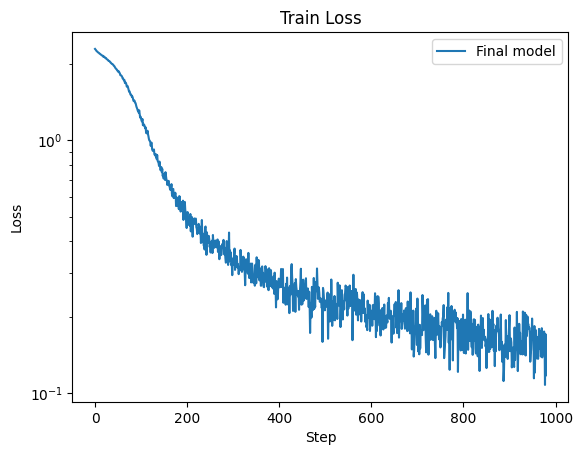

Train Loss Final model: 0.11789868775474306


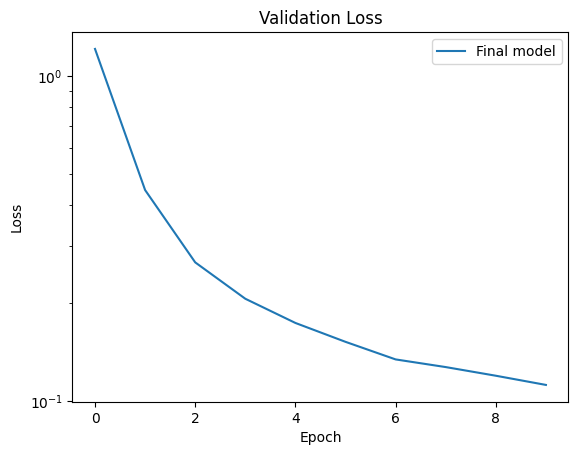

Validation Loss Final model: 0.11207894525674868


In [33]:
plot_losses(np.array([train_losses]), np.array([val_losses]), labels=['Final model'])

Print here your accuracy on test set. It should be around 90%.

In [34]:
from sklearn.metrics import accuracy_score

model.evaluate()
probas = model.forward(X_test)
predictions = probas.argmax(axis=-1)

print(f'Accuracy : {accuracy_score(predictions, y_test)}')

Accuracy : 0.9661


_Looks nice :)_

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [35]:
# Your beautiful code here.
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(X_train.shape[1] * X_train.shape[2], 128),
        nn.ReLU(),
        nn.Dropout(),
        nn.BatchNorm1d(128),
        nn.Linear(128, n_classes),
        nn.LogSoftmax(dim=-1)
)

optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.NLLLoss()
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Linear(in_features=128, out_features=10, bias=True)
  (6): LogSoftmax(dim=-1)
)

In [36]:
def train_loop_torch(model, X, y, batch_size, n_epoch, criterion, optimizer, scheduler, X_val, y_val):
    train_loss_history = []
    val_loss_history = []

    for _ in tqdm(range(n_epoch)):
        for x_batch, y_batch in get_batches((X, y), batch_size):
            model.train()
            # Forward
            predictions = model.forward(torch.FloatTensor(x_batch).unsqueeze(1).to(device))
            loss = criterion(predictions, torch.LongTensor(y_batch).to(device))

            # Backward
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()    
            
            train_loss_history.append(loss.item())
        
            model.eval()
            with torch.no_grad():
                predictions = model.forward(torch.FloatTensor(X_val).unsqueeze(1).to(device))
                val_loss = criterion(predictions, torch.LongTensor(y_val).to(device))
                val_loss_history.append(val_loss.item())
        scheduler.step()

    return train_loss_history, val_loss_history

In [37]:
train_losses, val_losses = train_loop_torch(model=model, X=X_train, y=y_train, 
                                            n_epoch=30, batch_size=512, 
                                            criterion=criterion, optimizer=optimizer, scheduler=scheduler,
                                            X_val=X_val, y_val=y_val)

  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_335768/3588526475.py:23: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  val_loss = criterion(predictions, torch.LongTensor(y_val).to(device))
100%|██████████| 30/30 [00:10<00:00,  2.83it/s]


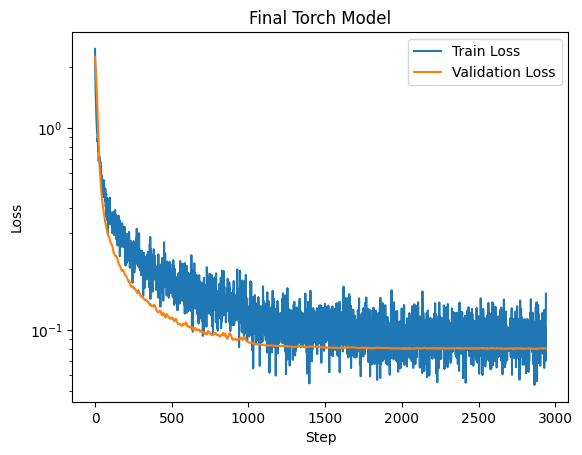

In [38]:
plt.plot(np.array(train_losses), label='Train Loss')
plt.plot(np.array(val_losses), label='Validation Loss')
plt.title('Final Torch Model')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import accuracy_score

model.eval()
with torch.no_grad():
    probas = model.forward(torch.FloatTensor(X_test).unsqueeze(1).to(device))
    predictions = probas.argmax(dim=-1).cpu().numpy()

print(f'Accuracy : {accuracy_score(predictions, y_test)}')

Accuracy : 0.9748


_Looks very nice :)_